In [ ]:
# Can ignore this line, cuz i use Google Colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import re
import os
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

import nltk
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords, wordnet

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
data = pd.read_csv("train_df_imbalanced.csv")
data

,Unnamed: 0,productAsin,ratingScore,reviewTitle,reviewReaction,reviewDescription,isVerified,category,languages,concat_review,polarity
0,9406,B08NLXR9V5,4,Girl Alone,One person found this helpful,"My first Blake Pierce book was enjoyable, fast...",True,mystery,Language.ENGLISH,Girl Alone. My first Blake Pierce book was enj...,1
1,5701,670062510,5,A great book for young people. It has a great...,NaN,My favorite book when I was young. I read it ...,True,children,Language.ENGLISH,A great book for young people. It has a great...,1
2,13621,1542046599,1,More gripes than hypes,One person found this helpful,This is the first book I‚Äôve read by this aut...,True,mystery,Language.ENGLISH,More gripes than hypes. This is the first book...,-1
3,5021,399226907,5,Add this book to your collection,NaN,Cute and educational book to teach counting an...,True,children,Language.ENGLISH,Add this book to your collection. Cute and edu...,1
4,21354,125030170X,2,Just okay.,NaN,This is one of those books you can read in a c...,False,children,Language.ENGLISH,Just okay.. This is one of those books you can...,0
...,...,...,...,...,...,...,...,...,...,...,...
20956,12474,1542046599,5,Great read; couldn‚Äôt put it down,NaN,The first chapter reads from an odd point of v...,True,mystery,Language.ENGLISH,Great read; couldn‚Äôt put it down. The first ...,1
20957,22518,125030170X,1,Used books?,NaN,They are purchased as new and I received the o...,True,children,Language.ENGLISH,Used books?. They are purchased as new and I r...,-1
20958,5670,670062510,4,My 7th graders not only love this book but the...,NaN,My 7th graders not only love this book but the...,True,children,Language.ENGLISH,My 7th graders not only love this book but the...,1
20959,891,B01IW9TM5O,5,One of my favorite books ever - read almost al...,One person found this helpful,One of my favorite books ever - read almost al...,True,humor_entertainment,Language.ENGLISH,One of my favorite books ever - read almost al...,1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


7518
197
13246


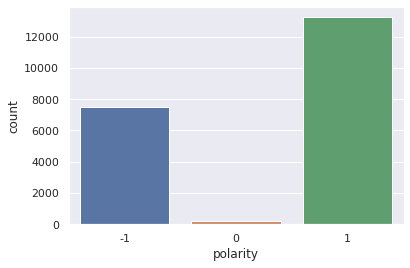

In [ ]:
# View the polarity 
sb.countplot(data["polarity"])

neg = data[data['polarity'] == -1]
neu = data[data['polarity'] == 0]
pos = data[data['polarity'] == 1]

print(len(neg))
print(len(neu))
print(len(pos))

In [ ]:
# Balance positive and negative reviews
pos = pos.head(n=len(neg))
print(len(pos))

7518


In [ ]:
# Create the new train data with the balanced datasets (POS and NEG)
train_data = pd.concat([neg, neu, pos], ignore_index = True)
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15233 entries, 0 to 15232
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         15233 non-null  int64 
 1   productAsin        15233 non-null  object
 2   ratingScore        15233 non-null  int64 
 3   reviewTitle        15232 non-null  object
 4   reviewReaction     5087 non-null   object
 5   reviewDescription  15233 non-null  object
 6   isVerified         15233 non-null  bool  
 7   category           15233 non-null  object
 8   languages          15233 non-null  object
 9   concat_review      15233 non-null  object
 10  polarity           15233 non-null  int64 
dtypes: bool(1), int64(3), object(7)
memory usage: 1.2+ MB
None


In [ ]:
print(train_data.polarity.value_counts())

-1    7518
 1    7518
 0     197
Name: polarity, dtype: int64


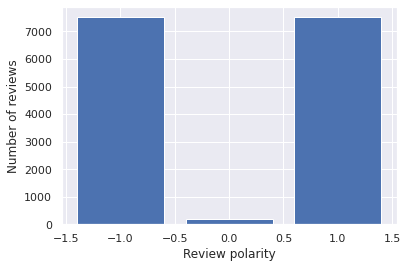

In [ ]:
sentiment_count = train_data.groupby('polarity').count()
plt.bar(sentiment_count.index.values, sentiment_count['reviewDescription'])
plt.xlabel('Review polarity')
plt.ylabel('Number of reviews')
plt.show()

In [ ]:
!pip install contractions
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# WHAT is this? LOVED. COME ON! !@#! get rid of punctuations
# Contraction words I've = I have
# removal of stop words
# removal of numbers

import contractions
import emoji
import string 
import pandas as pd
import numpy as np
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Remove emojis 
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF" 
        u"\U00002500-\U00002BEF"  
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)


# change to lower_case
def lower_case(review):
    
    return review.lower()

# change contraction words such sa I'm = I am, shouldn't = should not
def change_contractions(review):
    
    expanded_words = [contractions.fix(word) for word in review.split()]

    expanded_review = ' '.join(expanded_words)
    return expanded_review

# Remove Punctuations
def remove_punctuations(review):
    
    new_review = review.translate(str.maketrans('', '', string.punctuation))
    return new_review

# Remove numbers, we choose to remove numbers is because we find that for instance a review is descrbing about something "the 2 girls in the book is so cute"
# it could lead to 2 star review. Because we realize that, those negative reviews user, will include numbers in their reviews.
# Example: I give 2 star is because, the book is completely no link, also the words used in the book have a lot of grammatical error
# As classification is supervised learning model, it is trained by using the corpus with respect to the (sentiment category). Thus, 
# if the number 2 appear even in a positive comment, it may in the end up in the negative comment depending on how strong the number 2 in the corpus is.
# Thus, this will make the predictions go wrong. To reduce confusion for the model to learn, we decided to remove numbers
def remove_numbers(review):
    
    mapping = str.maketrans('', '', string.digits)
    new_review = review.translate(mapping)
    
    return new_review

# Remove extra whitespaces
def remove_extra_whitespace(reviews):
    return " ".join(reviews.split())

# We dont want to remove words that are from the whitelist, the reason is because it can have better meaning in our sentences
# The reason why i dont want remove one two three four etc is because, for instance if a user comment One start, this could mean it is a negative review straight away
def remove_stopwords(text):
    stopwords_list = stopwords.words('english')
    whitelist = ["not", "no", "cannot", "do", "must", "should", "would", "could", "One", "Two", "Three", "Four", "Five", "one", "two", "three", "four", "five"]
    words = text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1]
    return " ".join(clean_words)

def get_wordnet_pos(text):
    # Map POS tag to first character lemmatize() accepts
    tags = nltk.pos_tag(text)
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    tags = [tag_dict.get(tag[1][0],  wordnet.NOUN) for tag in tags]
    return tags

def lemmaSentence(reviews):
    lemmatizer = WordNetLemmatizer()
    lemma_text = ''
    tok_text = word_tokenize(reviews)
    tags = get_wordnet_pos(tok_text)
    for i in range(len(tok_text)):
        lemma_text = lemma_text + ' ' + lemmatizer.lemmatize(tok_text[i], tags[i])
    return lemma_text[1:] 

In [ ]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
# Feel free to include others preprocessing tehcnique that you want, like lemmatization etc.
# -----------------------------------------------------------------------------------------
# The main function to clean text
def clean_text(data):
    
    data['concat_review'] = data['concat_review'].astype(str);
    data['concat_review'] = data['concat_review'].apply(lower_case)
    data['concat_review'] = data['concat_review'].apply(change_contractions)
    data['concat_review'] = data['concat_review'].apply(remove_emojis)
    data['concat_review'] = data['concat_review'].apply(remove_punctuations)
    data['concat_review'] = data['concat_review'].apply(remove_numbers)
    data['concat_review'] = data['concat_review'].apply(remove_stopwords)
    data['concat_review'] = data['concat_review'].apply(remove_extra_whitespace)
    data['concat_review'] = data['concat_review'].apply(lemmaSentence)
    return data

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Analyze some of the stopwords removal by ntlk.
stopwords_list = stopwords.words('english')

In [ ]:
# Concantenate the reviewTitle with reviewDescription to provide more insights,
# helps for bette prediction, because normally reviewTitle is a summarise of their rating
# Clean the dataset remove unnecessary words
train_data['concat_review'] = train_data['reviewTitle'] + '. ' + train_data['reviewDescription']
train_data

,Unnamed: 0,productAsin,ratingScore,reviewTitle,reviewReaction,reviewDescription,isVerified,category,languages,concat_review,polarity
0,13621,1542046599,1,More gripes than hypes,One person found this helpful,This is the first book I‚Äôve read by this aut...,True,mystery,Language.ENGLISH,More gripes than hypes. This is the first book...,-1
1,23286,63215381,1,The paperback‚Äôs quality sucks,1,I hate this paperback. Terrible quality! The p...,True,children,Language.ENGLISH,The paperback‚Äôs quality sucks. I hate this p...,-1
2,341,451524934,4,1984,NaN,1984 was an enthralling but scary book! I kept...,True,humor_entertainment,Language.ENGLISH,1984. 1984 was an enthralling but scary book! ...,-1
3,19201,1250069831,1,Do not waste your time,NaN,There was nothing good about this book. From s...,True,humor_entertainment,Language.ENGLISH,Do not waste your time. There was nothing good...,-1
4,18756,525522131,1,The worst - would not recommend!! :(,2,This was the worst - trying too hard to be fun...,True,humor_entertainment,Language.ENGLISH,The worst - would not recommend!! :(. This was...,-1
...,...,...,...,...,...,...,...,...,...,...,...
15228,14333,B07GX3BR7P,5,A smart story.,NaN,Suspension to the last minute. Will definitely...,True,mystery,Language.ENGLISH,A smart story.. Suspension to the last minute....,1
15229,8611,141501596,5,I love it!,NaN,It's small but just like I remember when I was...,True,children,Language.ENGLISH,I love it!. It's small but just like I remembe...,1
15230,3,451524934,5,Second greatest book ever written?,11 people found this helpful,"In short, Mr. Orwell (Blair) was a genius ahea...",True,humor_entertainment,Language.ENGLISH,"Second greatest book ever written?. In short, ...",1
15231,15842,1984806734,5,Highly recommend!,NaN,Beautiful. Absolutely beautiful. Can‚Äôt wait ...,False,romance,Language.ENGLISH,Highly recommend!. Beautiful. Absolutely beaut...,1


In [ ]:
clean_data = clean_text(train_data)
clean_data

,Unnamed: 0,productAsin,ratingScore,reviewTitle,reviewReaction,reviewDescription,isVerified,category,languages,concat_review,polarity
0,13621,1542046599,1,More gripes than hypes,One person found this helpful,This is the first book I‚Äôve read by this aut...,True,mystery,Language.ENGLISH,gripe hype first book i‚äôve read author think...,-1
1,23286,63215381,1,The paperback‚Äôs quality sucks,1,I hate this paperback. Terrible quality! The p...,True,children,Language.ENGLISH,paperback‚äôs quality suck hate paperback terr...,-1
2,341,451524934,4,1984,NaN,1984 was an enthralling but scary book! I kept...,True,humor_entertainment,Language.ENGLISH,enthral scary book keep say novel boyfriend wo...,-1
3,19201,1250069831,1,Do not waste your time,NaN,There was nothing good about this book. From s...,True,humor_entertainment,Language.ENGLISH,do not waste time nothing good book start fini...,-1
4,18756,525522131,1,The worst - would not recommend!! :(,2,This was the worst - trying too hard to be fun...,True,humor_entertainment,Language.ENGLISH,worst would not recommend bad try hard funny r...,-1
...,...,...,...,...,...,...,...,...,...,...,...
15228,14333,B07GX3BR7P,5,A smart story.,NaN,Suspension to the last minute. Will definitely...,True,mystery,Language.ENGLISH,smart story suspension last minute definitely ...,1
15229,8611,141501596,5,I love it!,NaN,It's small but just like I remember when I was...,True,children,Language.ENGLISH,love small like remember younger,1
15230,3,451524934,5,Second greatest book ever written?,11 people found this helpful,"In short, Mr. Orwell (Blair) was a genius ahea...",True,humor_entertainment,Language.ENGLISH,second great book ever write short mr orwell b...,1
15231,15842,1984806734,5,Highly recommend!,NaN,Beautiful. Absolutely beautiful. Can‚Äôt wait ...,False,romance,Language.ENGLISH,highly recommend beautiful absolutely beautifu...,1


In [ ]:
# Since we are predicting polarity in the forms of -1/0/1 and is three classes so we need to use categorical cross entropy
clean_data = train_data
y = pd.get_dummies(clean_data['polarity']).values
y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]], dtype=uint8)

In [ ]:
# Tokenize the reviewDescription
from nltk import word_tokenize, WordNetLemmatizer
tokens = [word_tokenize(text) for text in clean_data.reviewDescription]
tokens

[['This',
  'is',
  'the',
  'first',
  'book',
  'I‚Äôve',
  'read',
  'by',
  'this',
  'author',
  'and',
  'thought',
  'I',
  'would',
  'roll',
  'the',
  'dice',
  'and',
  'give',
  'her',
  'a',
  'try',
  '.',
  'The',
  'first',
  'thing',
  'that',
  'bothered',
  'me',
  'was',
  'that',
  'the',
  'story',
  'felt',
  'choppy',
  '.',
  'Not',
  'just',
  'because',
  'there',
  'doesn‚Äôt',
  'seem',
  'to',
  'be',
  'a',
  'very',
  'clear',
  'main',
  'character',
  'to',
  'follow',
  'or',
  'that',
  'you',
  'are',
  'following',
  'several',
  'people',
  'at',
  'once',
  'from',
  'different',
  'perspectives',
  'but',
  'also',
  'because',
  'each',
  'chapter',
  'ends',
  'in',
  'a',
  'cliff',
  'hanger',
  'leaving',
  'the',
  'reader',
  'unsatisfied',
  'throughout',
  'the',
  'whole',
  'book',
  '.',
  'As',
  'a',
  'result',
  'of',
  'the',
  'writing',
  'style',
  'I',
  'didn‚Äôt',
  'feel',
  'connected',
  'to',
  'any',
  'of',
  'the',


In [ ]:
# Create your own word2vec using gensim
from gensim.models import KeyedVectors, Word2Vec

W2V_SIZE = 300 # represents how big your dimensional size of your word2vec, 
W2V_WINDOW = 5 # Window_Size refers to the how far your want this word to be 5, equal to (n-4) (n-3)....n, n(n+1)....n(n+5)word
W2V_EPOCH = 32 # Number of epochs to train the word2vec
W2V_MIN_COUNT = 2 # This mean that, if the word that occurs less than 2 times, will be drop away from the dictionary

word2vec_model = Word2Vec(size=W2V_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT, workers=8)

In [ ]:
word2vec_model.build_vocab(tokens)

In [ ]:
word2vec_model.train(tokens, total_examples=len(tokens), epochs=32)

(24285974, 34726528)

In [ ]:
word2vec_model.wv.most_similar("bad") # This shows the relationship of some words shared the same similaritiy as "bad", based on cosine similarity

[('good', 0.5334099531173706),
 ('terrible', 0.4680095911026001),
 ('horrible', 0.44306886196136475),
 ('awful', 0.412789911031723),
 ('poor', 0.38837045431137085),
 ('okay', 0.38523921370506287),
 ('negative', 0.3812371492385864),
 ('overhyped', 0.34555506706237793),
 ('disappointing', 0.34381362795829773),
 ('cheap', 0.34335857629776)]

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_data.reviewDescription)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size) # Shows the vocacbulary size of the datasets

Total words 25006


In [ ]:
# Split the datasets to train/test
from sklearn.model_selection import train_test_split

random_seed = 42
X = clean_data['reviewDescription']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [ ]:
# Obtain the longest string of text
text_length =  clean_data['reviewDescription'].str.len()
max_len = max(text_length)
max_len  

15054

In [ ]:
# Pad the sequences to make all the same == maxlength
# By right when we doing padding our sequences, the maxlen argument must be maxlen of the longest in text
# But however, the longest review in our dataset is 20849. freaking long....
# Therefore, to prevent the high dimensional Word2Vec from going into RAM memory overload, we only read first 500 word

from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=500)
x_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=500)

In [ ]:
# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]
print(embedding_matrix.shape)

(25006, 300)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=500)

In [ ]:
# Creating a LSTM Model 
# Dropout is use to prevent the model from overfitting
LSTM_model = Sequential()
LSTM_model.add(embedding_layer)
LSTM_model.add(Dropout(0.5))
LSTM_model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
LSTM_model.add(Dense(3, activation='softmax'))
LSTM_model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Callbacks to incurr earlystopping
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [ ]:
# Currently i only trained on 5epochs, but it can be increase to like 10-20 for better performance
# You can see the loss is decreasing consistently, which shows that is a good sign, that the model is not overfitting
# During fitting, the model will test again validation set, I set to 10%(y_train)
LSTM_model.fit(x_train, y_train,
                batch_size=32,
                epochs=10,
                validation_split=0.1,
                verbose=1,
                callbacks=callbacks)

Epoch 1/10
343/343 [==============================] - ETA: 0s - loss: 0.5589 - accuracy: 0.7495

343/343 [==============================] - 679s 2s/step - loss: 0.5589 - accuracy: 0.7495 - val_loss: 0.4178 - val_accuracy: 0.8450 - lr: 0.0010
Epoch 2/10
343/343 [==============================] - ETA: 0s - loss: 0.3974 - accuracy: 0.8476

343/343 [==============================] - 663s 2s/step - loss: 0.3974 - accuracy: 0.8476 - val_loss: 0.3826 - val_accuracy: 0.8573 - lr: 0.0010
Epoch 3/10
343/343 [==============================] - ETA: 0s - loss: 0.3385 - accuracy: 0.8736

343/343 [==============================] - 671s 2s/step - loss: 0.3385 - accuracy: 0.8736 - val_loss: 0.4085 - val_accuracy: 0.8548 - lr: 0.0010
Epoch 4/10
343/343 [==============================] - ETA: 0s - loss: 0.3038 - accuracy: 0.8894

343/343 [==============================] - 669s 2s/step - loss: 0.3038 - accuracy: 0.8894 - val_loss: 0.3497 - val_accuracy: 0.8720 - lr: 0.0010
Epoch 5/10
343/343 [==============================] - ETA: 0s - loss: 0.2639 - accuracy: 0.9033

343/343 [==============================] - 668s 2s/step - loss: 0.2639 - accuracy: 0.9033 - val_loss: 0.3877 - val_accuracy: 0.8712 - lr: 0.0010
Epoch 6/10
343/343 [==============================] - ETA: 0s - loss: 0.2373 - accuracy: 0.9146

343/343 [==============================] - 671s 2s/step - loss: 0.2373 - accuracy: 0.9146 - val_loss: 0.3981 - val_accuracy: 0.8679 - lr: 0.0010
Epoch 7/10
343/343 [==============================] - ETA: 0s - loss: 0.1951 - accuracy: 0.9310

343/343 [==============================] - 680s 2s/step - loss: 0.1951 - accuracy: 0.9310 - val_loss: 0.4203 - val_accuracy: 0.8720 - lr: 0.0010
Epoch 8/10
343/343 [==============================] - ETA: 0s - loss: 0.1732 - accuracy: 0.9385

343/343 [==============================] - 671s 2s/step - loss: 0.1732 - accuracy: 0.9385 - val_loss: 0.4787 - val_accuracy: 0.8687 - lr: 0.0010
Epoch 9/10
343/343 [==============================] - ETA: 0s - loss: 0.1503 - accuracy: 0.9445

343/343 [==============================] - 675s 2s/step - loss: 0.1503 - accuracy: 0.9445 - val_loss: 0.5055 - val_accuracy: 0.8638 - lr: 0.0010
Epoch 10/10
343/343 [==============================] - ETA: 0s - loss: 0.1230 - accuracy: 0.9576

343/343 [==============================] - 673s 2s/step - loss: 0.1230 - accuracy: 0.9576 - val_loss: 0.5244 - val_accuracy: 0.8663 - lr: 1.0000e-04


In [ ]:
# help function to obtain true_pred
def get_true_pred(predictions, y_test):
    neg_count, neu_count, pos_count = 0, 0, 0
    real_neg, real_neu, real_pos = 0, 0, 0

    y_pred = []
    y_true = []

    for i, prediction in enumerate(predictions):
        if np.argmax(prediction) == 0:
            neg_count += 1
        elif np.argmax(prediction) == 1:
            neu_count += 1
        else:
            pos_count += 1

        y_pred.append(np.argmax(prediction))

        if np.argmax(y_test[i]) == 0:
            real_neg += 1
        elif np.argmax(y_test[i]) == 1:    
            real_neu += 1
        else:
            real_pos +=1

        y_true.append(np.argmax(y_test[i]))

    print('Negative predictions:', neg_count)
    print('Neutral predictions:', neu_count)
    print('Positive predictions:', pos_count)
    print('True negative:', real_neg)
    print('True neutral:', real_neu)
    print('True positive:', real_pos)
    
    return y_true, y_pred

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# A helper function for creating Confusion Matrix
def Confusion_Matrix(y_true, y_pred, model_name):
    
    cm = confusion_matrix(y_true, y_pred)
    conf_matrix=pd.DataFrame(data=cm,columns=['Predicted: -1','Predicted: 0','Predicted: 1'],
                                         index=['Actual: -1','Actual: 0','Actual: 1'])
                                                        
    plt.figure(figsize = (10,5))
    sb.set(font_scale=1.2)
    sb.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")
    plt.title(f"Confusion Matrix for Sentiment Analysis using {model_name}")
    plt.yticks(rotation=360)
    plt.show()

    print(f"Confusion Matrix for Sentiment Analysis using {model_name}:",accuracy_score(y_true, y_pred))
    print("-"*100)
    print(f"Classification Report for Sentiment Analysis using {model_name}:\n\n",classification_report(y_true, y_pred))
    print("-"*100)
    Negative = cm[0][0]/(cm[0][0]+cm[0][1]+cm[0][2])*100
    print("Negative has a accuracy of {} %".format(Negative))
    print()
    Neutral = cm[1][1]/(cm[1][1]+cm[1][0]+cm[1][2])*100
    print("Neutral has a accuracy of {} %".format(Neutral))
    print()
    Positive = cm[2][2]/(cm[2][2]+cm[2][0]+cm[2][1])*100
    print("Positive has a accuracy of {} %".format(Positive))

96/96 [==============================] - 23s 232ms/step
Negative predictions: 1501
Neutral predictions: 1
Positive predictions: 1545
True negative: 1521
True neutral: 38
True positive: 1488


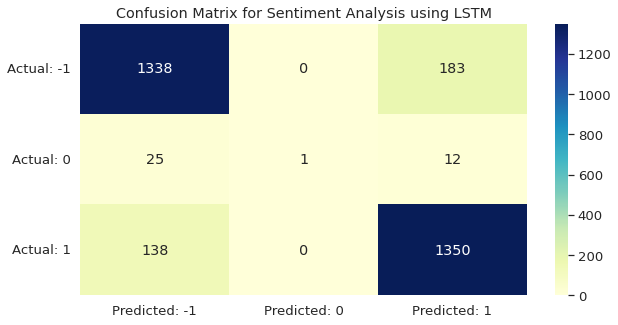

Confusion Matrix for Sentiment Analysis using LSTM: 0.8825073843124385
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using LSTM:

               precision    recall  f1-score   support

           0       0.89      0.88      0.89      1521
           1       1.00      0.03      0.05        38
           2       0.87      0.91      0.89      1488

    accuracy                           0.88      3047
   macro avg       0.92      0.60      0.61      3047
weighted avg       0.88      0.88      0.88      3047

----------------------------------------------------------------------------------------------------
Negative has a accuracy of 87.96844181459566 %

Neutral has a accuracy of 2.631578947368421 %

Positive has a accuracy of 90.7258064516129 %


In [ ]:
pred = LSTM_model.predict(x_test)
y_true, y_pred = get_true_pred(pred, y_test)
Confusion_Matrix(y_true, y_pred, "LSTM")

In [ ]:
# Testing on unseen data INPUT TEXT .... 

In [ ]:
# Concatenate the data
bryson_data = pd.read_csv("test_df_Bryson.csv")
gx_data = pd.read_csv("test_df_Gx.csv")
kelvin_data = pd.read_csv("test_df_Kelvin.csv")

combine_test_data = pd.concat([bryson_data, gx_data, kelvin_data], ignore_index=True)
combine_test_data

,Unnamed: 0,Unnamed: 0.1,productAsin,ratingScore,reviewTitle,reviewReaction,reviewDescription,isVerified,category,languages,Annotator_1,Annotator_2,Unnamed: 0.1.1
0,0,24031,1982137452,1,The content is all messed up,NaN,I started this book this week for my book club...,True,children,Language.ENGLISH,-1,-1,NaN
1,1,22332,125030170X,1,Duplicate copy.Damaged book.,NaN,Pages missing.,True,children,Language.ENGLISH,-1,-1,NaN
2,2,23579,63215381,1,Awful,NaN,I gave up after 38% of my Kindle. Yes we were ...,True,children,Language.ENGLISH,-1,-1,NaN
3,3,20346,60935464,1,Syrupy Overload,3,The book is an example of leading the witness.,True,children,Language.ENGLISH,-1,-1,NaN
4,4,22874,1501161938,1,Couldn‚Äôt read it; type too small!,1,"Beware, the type is TINY, I mean TINY. I am 60...",True,children,Language.ENGLISH,-1,-1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2325,771,22580,125030170X,1,No,NaN,Just awful!,False,children,Language.ENGLISH,-1,-1,NaN
2326,772,21540,125030170X,2,Bored,NaN,I was so bored reading this book. I switched o...,True,children,Language.ENGLISH,-1,-1,NaN
2327,773,23190,194563183X,1,Ugh!,2,"Ugh! Too wordy, predictable and shallow. I am ...",True,children,Language.ENGLISH,-1,-1,NaN
2328,774,2730,1982185821,5,A story that made me cry,One person found this helpful,I have so many fond memories of Sam from Iclar...,True,humor_entertainment,Language.ENGLISH,1,1,NaN


In [ ]:
combine_test_data['concat_review'] = combine_test_data['reviewTitle'] + '. ' + combine_test_data['reviewDescription']
combine_test_data

,Unnamed: 0,Unnamed: 0.1,productAsin,ratingScore,reviewTitle,reviewReaction,reviewDescription,isVerified,category,languages,Annotator_1,Annotator_2,Unnamed: 0.1.1,concat_review
0,0,24031,1982137452,1,The content is all messed up,NaN,I started this book this week for my book club...,True,children,Language.ENGLISH,-1,-1,NaN,The content is all messed up. I started this b...
1,1,22332,125030170X,1,Duplicate copy.Damaged book.,NaN,Pages missing.,True,children,Language.ENGLISH,-1,-1,NaN,Duplicate copy.Damaged book.. Pages missing.
2,2,23579,63215381,1,Awful,NaN,I gave up after 38% of my Kindle. Yes we were ...,True,children,Language.ENGLISH,-1,-1,NaN,Awful. I gave up after 38% of my Kindle. Yes w...
3,3,20346,60935464,1,Syrupy Overload,3,The book is an example of leading the witness.,True,children,Language.ENGLISH,-1,-1,NaN,Syrupy Overload. The book is an example of lea...
4,4,22874,1501161938,1,Couldn‚Äôt read it; type too small!,1,"Beware, the type is TINY, I mean TINY. I am 60...",True,children,Language.ENGLISH,-1,-1,NaN,"Couldn‚Äôt read it; type too small!. Beware, t..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2325,771,22580,125030170X,1,No,NaN,Just awful!,False,children,Language.ENGLISH,-1,-1,NaN,No. Just awful!
2326,772,21540,125030170X,2,Bored,NaN,I was so bored reading this book. I switched o...,True,children,Language.ENGLISH,-1,-1,NaN,Bored. I was so bored reading this book. I swi...
2327,773,23190,194563183X,1,Ugh!,2,"Ugh! Too wordy, predictable and shallow. I am ...",True,children,Language.ENGLISH,-1,-1,NaN,"Ugh!. Ugh! Too wordy, predictable and shallow...."
2328,774,2730,1982185821,5,A story that made me cry,One person found this helpful,I have so many fond memories of Sam from Iclar...,True,humor_entertainment,Language.ENGLISH,1,1,NaN,A story that made me cry. I have so many fond ...


In [ ]:
# Clean the dataset remove unnecessary words
combine_test_clean = clean_text(combine_test_data)
combine_test_clean

,Unnamed: 0,Unnamed: 0.1,productAsin,ratingScore,reviewTitle,reviewReaction,reviewDescription,isVerified,category,languages,Annotator_1,Annotator_2,Unnamed: 0.1.1,concat_review
0,0,24031,1982137452,1,The content is all messed up,NaN,I started this book this week for my book club...,True,children,Language.ENGLISH,-1,-1,NaN,content mess start book week book club can‚äôt...
1,1,22332,125030170X,1,Duplicate copy.Damaged book.,NaN,Pages missing.,True,children,Language.ENGLISH,-1,-1,NaN,duplicate copydamaged book page miss
2,2,23579,63215381,1,Awful,NaN,I gave up after 38% of my Kindle. Yes we were ...,True,children,Language.ENGLISH,-1,-1,NaN,awful give kindle yes tell someone die do not ...
3,3,20346,60935464,1,Syrupy Overload,3,The book is an example of leading the witness.,True,children,Language.ENGLISH,-1,-1,NaN,syrupy overload book example lead witness
4,4,22874,1501161938,1,Couldn‚Äôt read it; type too small!,1,"Beware, the type is TINY, I mean TINY. I am 60...",True,children,Language.ENGLISH,-1,-1,NaN,couldn‚äôt read type small beware type tiny me...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2325,771,22580,125030170X,1,No,NaN,Just awful!,False,children,Language.ENGLISH,-1,-1,NaN,no awful
2326,772,21540,125030170X,2,Bored,NaN,I was so bored reading this book. I switched o...,True,children,Language.ENGLISH,-1,-1,NaN,bore bore read book switch end first page
2327,773,23190,194563183X,1,Ugh!,2,"Ugh! Too wordy, predictable and shallow. I am ...",True,children,Language.ENGLISH,-1,-1,NaN,ugh ugh wordy predictable shallow go start cho...
2328,774,2730,1982185821,5,A story that made me cry,One person found this helpful,I have so many fond memories of Sam from Iclar...,True,humor_entertainment,Language.ENGLISH,1,1,NaN,story make cry many fond memory sam iclary sin...


In [ ]:
# Clean the test_dataset
unseen_X_test = combine_test_clean['concat_review'].values
unseen_Y_test = combine_test_clean['Annotator_1'].values

In [ ]:
# Tokenize to make it to vector format
sequences_test = tokenizer.texts_to_sequences(unseen_X_test)
unseen_X_test = pad_sequences(sequences_test, maxlen=50)
unseen_X_test

array([[   0,    0,    0, ...,  274,    9,  386],
       [   0,    0,    0, ...,    9,  140, 1411],
       [   0,    0,    0, ...,  413,  397,  735],
       ...,
       [   0,    0,    0, ...,  211,  258,   57],
       [   0,    0,    0, ...,  678,  145, 2098],
       [   0,    0,    0, ..., 2443,  595,  185]], dtype=int32)

In [ ]:
# Make it to a one-hot encoding using pd.get_dummies, so that cateogircal entropy can be utilized
unseen_Y_test = pd.get_dummies(unseen_Y_test).values
unseen_Y_test

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0]], dtype=uint8)

73/73 [==============================] - 3s 30ms/step
Negative predictions: 940
Neutral predictions: 1
Positive predictions: 1389
True negative: 648
True neutral: 103
True positive: 1579


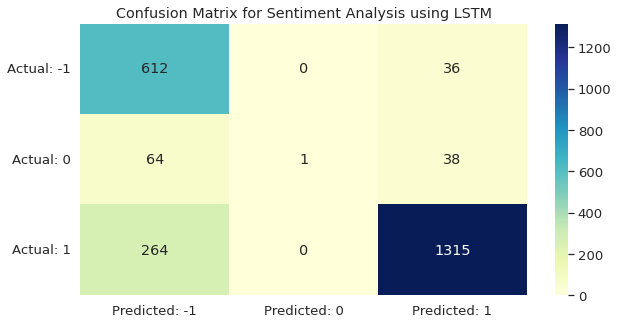

Confusion Matrix for Sentiment Analysis using LSTM: 0.8274678111587983
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using LSTM:

               precision    recall  f1-score   support

           0       0.65      0.94      0.77       648
           1       1.00      0.01      0.02       103
           2       0.95      0.83      0.89      1579

    accuracy                           0.83      2330
   macro avg       0.87      0.60      0.56      2330
weighted avg       0.87      0.83      0.82      2330

----------------------------------------------------------------------------------------------------
Negative has a accuracy of 94.44444444444444 %

Neutral has a accuracy of 0.9708737864077669 %

Positive has a accuracy of 83.28055731475618 %


In [ ]:
pred = LSTM_model.predict(unseen_X_test)
y_true, y_pred = get_true_pred(pred, unseen_Y_test)
Confusion_Matrix(y_true, y_pred, "LSTM")

In [1]:
# This is a the result after training for 10 epochs

In [ ]:
## Test on self written text

In [ ]:
# first array element denotes negative, second array element denotes neutral, third element denotes positive
text = "I love the book, it is so good!"
token_text = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=500)
LSTM_model.predict(token_text)

1/1 [==============================] - 0s 121ms/step


array([[6.496505e-04, 6.918043e-05, 9.992812e-01]], dtype=float32)

In [ ]:
# first array element denotes 0, second array element denotes neutral, third element denotes positive
text = "I love the book, but the delivery service is trash"
token_text = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=500)
LSTM_model.predict(token_text)

1/1 [==============================] - 0s 141ms/step


array([[0.97000253, 0.00734955, 0.02264792]], dtype=float32)

In [ ]:
# first array element denotes 0, second array element denotes neutral, third element denotes positive
text = "the book is okay only"
token_text = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=500)
LSTM_model.predict(token_text)

1/1 [==============================] - 0s 108ms/step


array([[0.9392866 , 0.03103224, 0.02968111]], dtype=float32)

In [ ]:
# first array element denotes 0, second array element denotes neutral, third element denotes positive
text = "i don't why the rating is so high"
token_text = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=500)
LSTM_model.predict(token_text)

1/1 [==============================] - 0s 109ms/step


array([[9.9941838e-01, 6.5753185e-05, 5.1587186e-04]], dtype=float32)

In [ ]:
# first array element denotes 0, second array element denotes neutral, third element denotes positive
text = "the rating don't tally with the book..."
token_text = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=500)
LSTM_model.predict(token_text)

1/1 [==============================] - 0s 106ms/step


array([[0.9758312 , 0.00107279, 0.02309601]], dtype=float32)

In [ ]:
# first array element denotes 0, second array element denotes neutral, third element denotes positive
text = "The books seam fine, but the box that holds the series is torn.  I will be able to tape it and still use it to store the books, but I was disappointed. "
token_text = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=500)
LSTM_model.predict(token_text)

1/1 [==============================] - 0s 104ms/step


array([[9.9985600e-01, 6.4480606e-05, 7.9548532e-05]], dtype=float32)